# **Project Leyenda - Deliverable 2**

*Group* : 
|Author|Center|Promo|Mail| 
|---|---|---|---|
|De Jesus Correia Alexandre|Nanterre|FISE INFO A5|alexandre.dejesuscorreia@viacesi.fr|
|Charlut Steven|Nanterre|FISE INFO A5|steven.charlut@viacesi.fr|
|Debraize Killian|Nanterre|FISE INFO A5|killian.debraize@viacesi.fr|
|Raies Youssef|Nanterre|FISE INFO A5|youssef.raies@viacesi.fr|
|Kinya Mwongera Sharon|Nanterre|FISE INFO A5|sharon.kinyamwongera@viaceis.fr|

![denoizing](https://i.imgflip.com/96cuk7.jpg)

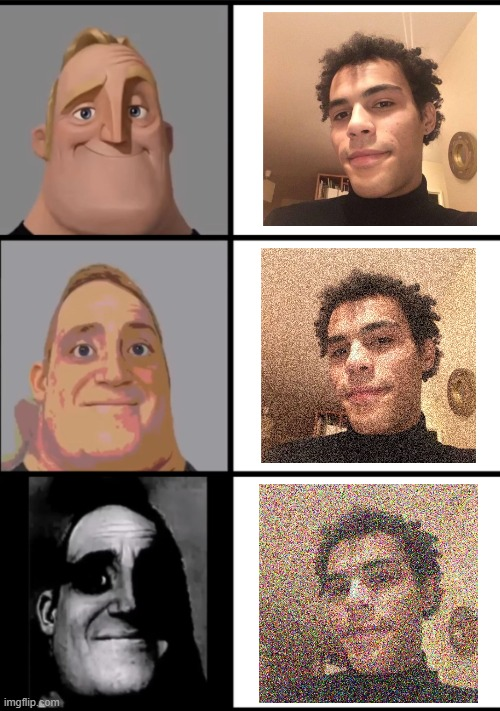


In [67]:
%matplotlib inline

In [68]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Conv2DTranspose, Concatenate, BatchNormalization, ReLU
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# 1. File Loading Section
## Load the dataset 


In [69]:
# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)  
    return images  

base_dir = os.getcwd()
relative_path = r"..\..\DataSets\data_set_livrable_2"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

# Load dataset and resize images
dataset_images = load_images_from_folder(dataset_dir)
num_images = len(dataset_images)
print(f"Nombre d'images dans notre dataset : {num_images}")

Nombre d'images dans notre dataset : 148


In [70]:
def load_images_with_check(folder):
    images = []
    corrupted_files = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)  
            else:
                corrupted_files.append(filename) 
        except Exception as e:
            print(f"Erreur lors du chargement de {filename}: {e}")
            corrupted_files.append(filename) 
    return images, corrupted_files

dataset_images, corrupted_files = load_images_with_check(dataset_dir)
# Afficher le nombre d'images corrompues
print(f"Nombre d'images corrompues ou manquantes : {len(corrupted_files)}")

Nombre d'images corrompues ou manquantes : 0


In [71]:
# Fonction pour redimensionner toutes les images du dataset à une taille donnée
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_img = resized_img.astype('float16') / 255.0  
        resized_images.append(resized_img)
    return np.array(resized_images, dtype=np.float16) 

def create_augmented_dataset(original_images, additional_images, target_size):
    num_images_to_add = target_size - len(original_images)
    additional_images_sample = random.sample(additional_images, num_images_to_add)
    augmented_dataset = original_images + additional_images_sample

    return augmented_dataset

base_dir = os.getcwd()
relative_path = r"..\..\DataSets\data_set_livrable_1\Photo"
additional_dataset_dir =  os.path.normpath(os.path.join(base_dir, relative_path))

additional_images, corrupted_files = load_images_with_check(additional_dataset_dir)
print("nombre de photo dans le data set suplémentaire :",len(additional_images))
print("nombre de photo corrompu dans ce même data set :",len(corrupted_files))

augmented_dataset_1000 = create_augmented_dataset(dataset_images, additional_images, 1000)
print(len(augmented_dataset_1000))
augmented_dataset_1000_resized128 = resize_images(augmented_dataset_1000, (128, 128))
print(augmented_dataset_1000_resized128.shape)

nombre de photo dans le data set suplémentaire : 9997
nombre de photo corrompu dans ce même data set : 0
1000
(1000, 128, 128, 3)


In [72]:
# Split the augmented dataset 1000 resized (128x128)
train_images_augmented_L1000_R128 = augmented_dataset_1000_resized128[:int(len(augmented_dataset_1000_resized128) * 0.8)]
test_images_augmented_L1000_R128  = augmented_dataset_1000_resized128[int(len(augmented_dataset_1000_resized128) * 0.8):]


In [73]:
# Add noise to the images
def create_data_set_noise_batch(noise_factor, train_images, test_images, batch_size=500):
    train_noisy = []
    test_noisy = []
    
    for i in range(0, len(train_images), batch_size):
        batch_train = train_images[i:i+batch_size]
        noise_train = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=batch_train.shape).astype('float32')
        noisy_batch_train = np.clip(batch_train + noise_train, 0., 1.)
        train_noisy.append(noisy_batch_train)
    
    for i in range(0, len(test_images), batch_size):
        batch_test = test_images[i:i+batch_size]
        noise_test = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=batch_test.shape).astype('float32')
        noisy_batch_test = np.clip(batch_test + noise_test, 0., 1.)
        test_noisy.append(noisy_batch_test)
    
    return np.vstack(train_noisy), np.vstack(test_noisy)

#Add noise to the augmented dataset 1000 resized (128x128)
train_noisy_augmented_L1000_R128, test_noisy_augmented_L1000_R128 = create_data_set_noise_batch(noise_factor=0.5,train_images = train_images_augmented_L1000_R128 ,test_images = test_images_augmented_L1000_R128,batch_size=500)
train_images_augmented_L1000_R128.shape
test_images_augmented_L1000_R128.shape

(200, 128, 128, 3)

In [79]:
# Configuration des dimensions des images
IMG_SIZE = 128                        # Taille des images (128x128)
IMG_CHANNELS = 3                      # Canaux des images (RVB)
NB_EPOCHS_DENOISE = 100               # nombre epoch alogithme debruiter
BATCH_SIZE        = 64          # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage
latent_dim = 256                  #latent space dimension
# Configuration de l'encodeur (input = image de 128x128 avec 3 canaux)
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
input_shape = (128, 128, 3)
from tensorflow.keras.layers import Reshape, Dropout
from tensorflow.keras.regularizers import l2

# Perte SSIM
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Encoder
input_img = tf.keras.Input(shape=input_shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)  # Réduction 128x128 -> 64x64
x = MaxPooling2D((2, 2), padding='same')(x)  

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)  # Réduction 64x64 -> 32x32
x = MaxPooling2D((2, 2), padding='same')(x)  

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu')(x)  # Réduction 32x32 -> 16x16
x = MaxPooling2D((2, 2), padding='same')(x)  # 128x128 -> 64x64

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
encoded = Conv2D(512, (3, 3), activation='relu')(x)  # Réduction 16x16 -> 8x8
encoded = MaxPooling2D((2, 2), padding='same')(x)  

from tensorflow.keras.optimizers import Adam, RMSprop
# Optimiseur RMSprop 
optimizer = RMSprop()
# Fonction de perte MSE 
loss = ssim_loss

# Decoder

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 8x8 -> 16x16

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 16x16 -> 32x32

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 32x32 -> 64x64

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Agrandir 64x64 -> 128x128

# Reconstruction finale
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Reconstruction finale

# Construire le modèle
autoencoder = Model(input_img, decoded)

# Compiler le modèle avec les meilleurs hyperparamètres
autoencoder.compile(optimizer=optimizer, loss=loss)
# Charger les poids dans l'autoencodeur
autoencoder.load_weights('C:\\Users\\djcal\\Downloads\\autoencoder_L1000_R128.weights.h5')

# Compiler le modèle avec les meilleurs hyperparamètres
# autoencoder.compile(optimizer=optimizer, loss=loss)

c:\Users\djcal\Documents\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [80]:
# Affichage du résumé du modèle
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 126, 126, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 63, 63, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 29, 29, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32768)          │     8,421,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 8, 8, 512)      │         2,04

 Total params: 23,053,763 (87.94 MB)

 Trainable params: 23,049,923 (87.93 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
'''
# Train the model
history_R128 = autoencoder.fit(
    train_noisy_augmented_L1000_R128, train_images_augmented_L1000_R128,     # Données d'entrée bruitées et images originales correspondantes
    epochs=NB_EPOCHS_DENOISE,   # Nombre d'epochs défini précédemment
    batch_size=BATCH_SIZE,      # Taille de batch définie précédemment
    shuffle=True,               # Shuffle des données à chaque epoch
    validation_data=(test_noisy_augmented_L1000_R128, test_images_augmented_L1000_R128),  # Validation avec les images de test bruitées et originales
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False), early_stopping]  # Une seule liste pour les callbacks
)
'''

"\n# Train the model\nhistory_R128 = autoencoder.fit(\n    train_noisy_augmented_L1000_R128, train_images_augmented_L1000_R128,     # Données d'entrée bruitées et images originales correspondantes\n    epochs=NB_EPOCHS_DENOISE,   # Nombre d'epochs défini précédemment\n    batch_size=BATCH_SIZE,      # Taille de batch définie précédemment\n    shuffle=True,               # Shuffle des données à chaque epoch\n    validation_data=(test_noisy_augmented_L1000_R128, test_images_augmented_L1000_R128),  # Validation avec les images de test bruitées et originales\n    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False), early_stopping]  # Une seule liste pour les callbacks\n)\n"

In [77]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
'''
plt.plot(history_R128.history['loss'], label='train')        # Pertes d'entraînement
plt.plot(history_R128.history['val_loss'], label='test')     # Pertes de validation
plt.legend("autoencodeur R128")
plt.title('Courbe d\'apprentissage')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
'''


'\nplt.plot(history_R128.history[\'loss\'], label=\'train\')        # Pertes d\'entraînement\nplt.plot(history_R128.history[\'val_loss\'], label=\'test\')     # Pertes de validation\nplt.legend("autoencodeur R128")\nplt.title(\'Courbe d\'apprentissage\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.show()\n'

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 954ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 937ms/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.6380 - val_loss: 0.6853
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - loss: 0.5871 - val_loss: 0.6810
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.5869 - val_loss: 0.6761
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.5847 - val_loss: 0.6734
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.5821 - val_loss: 0.6693
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.5879 - val_loss: 0.6653
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.5822 - val_loss: 0.6632
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.5868 - val_loss: 0.6617
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.5860 - val_loss: 0.6574
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.5870 - val_loss: 0.6487
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.5857 - val_loss: 

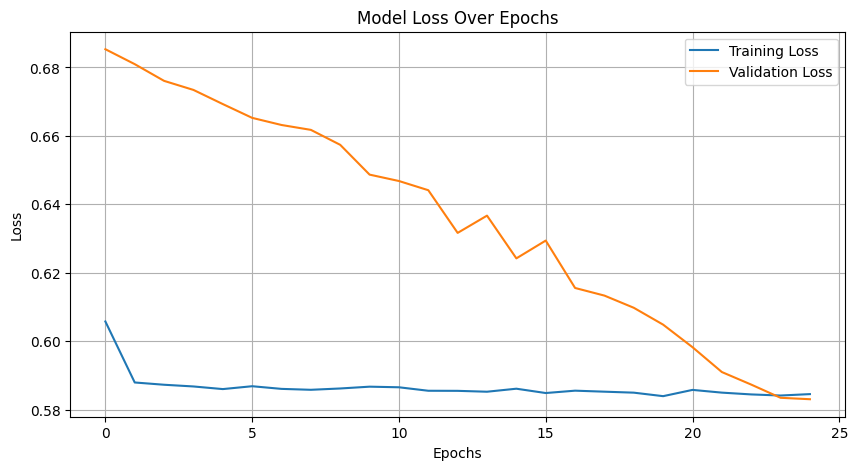

In [81]:
from tensorflow.keras.optimizers import Adam

# Split into training and test sets
train_blurred = autoencoder.predict(train_noisy_augmented_L1000_R128)
test_blurred = autoencoder.predict(test_noisy_augmented_L1000_R128)

# Define the convolutional autoencoder
input_img = Input(shape=(128, 128, 3))

# Encoder
C1 = Conv2D(64, (3,3), strides=2, padding='same')(input_img)
C1 = BatchNormalization()(C1)
C1 = ReLU()(C1)
C2 = Conv2D(128, (3,3), strides=2, padding='same')(C1)
C2 = BatchNormalization()(C2)
C2 = ReLU()(C2)
C3 = Conv2D(256, (3,3), strides=2, padding='same')(C2)
C3 = BatchNormalization()(C3)
C3 = ReLU()(C3)

C4 = Conv2D(256, (3,3), strides=1, padding='same')(C3)
C4 = BatchNormalization()(C4)
C4 = ReLU()(C4)

# Decoder
CT1 = Conv2DTranspose(256, (3,3), strides=2, padding='same')(C4)
CT1 = BatchNormalization()(CT1)
CT1 = ReLU()(CT1)
Co1 = Concatenate()([C2,CT1])
CT2 = Conv2DTranspose(128, (3,3), strides=2, padding='same')(Co1)
CT2 = BatchNormalization()(CT2)
CT2 = ReLU()(CT2)
Co2 = Concatenate()([C1,CT2])
CT3 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(Co2)
CT3 = BatchNormalization()(CT3)
CT3 = ReLU()(CT3)

decoder = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(CT3)

# Compile the autoencoder
autoencoder_blur = Model(input_img, decoder)
autoencoder_blur.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model
#autoencoder_blur.summary()

# Train the autoencoder
history = autoencoder_blur.fit(train_blurred, train_images_augmented_L1000_R128,   
                          epochs=25,                    
                          batch_size=32,                    
                          shuffle=True,         
                          validation_data=(test_blurred, test_images_augmented_L1000_R128))

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 827ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step


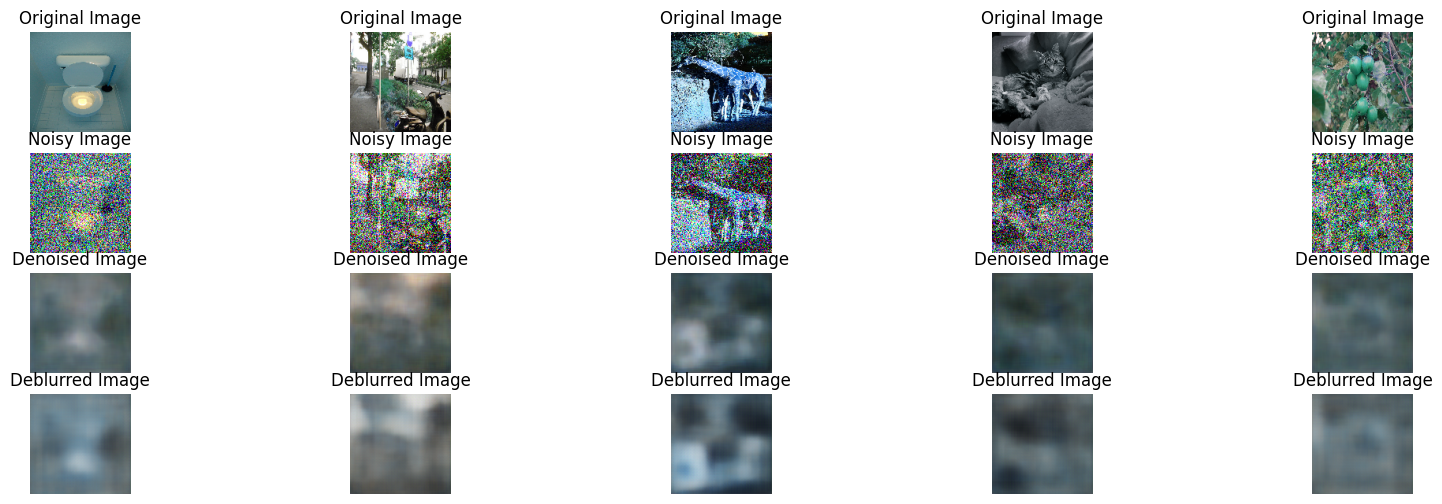

In [86]:
# Evaluate the autoencoder by comparing noisy images with denoised images
decoded_imgs = autoencoder.predict(test_noisy_augmented_L1000_R128)
decoded_imgs2 = autoencoder_blur.predict(decoded_imgs)

# Fonction pour normaliser les images pour l'affichage
def normalize_image(image):
    """
    Normalise les images à une plage de 0 à 1 pour une meilleure visualisation.
    """
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normaliser l'image
    return image.astype(np.float32)  # Assurez-vous que l'image est en float32

# Visualize the results
n = 5  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    
    # Display original images
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(normalize_image(test_images_augmented_L1000_R128[i]))
    plt.title("Original Image")
    plt.axis("off")
    
    # Display original noisy images
    ax = plt.subplot(4, n, i + n + 1)
    plt.imshow(normalize_image(test_noisy_augmented_L1000_R128)[i])
    plt.title("Noisy Image")
    plt.axis("off")

    # Display denoised images
    ax = plt.subplot(4, n, i + 2*n + 1)
    plt.imshow(normalize_image(decoded_imgs)[i])
    plt.title("Denoised Image")
    plt.axis("off")
    
    # Display deblurred images
    ax = plt.subplot(4, n, i + 3*n + 1)
    plt.imshow(normalize_image(decoded_imgs2)[i])
    plt.title("Deblurred Image")
    plt.axis("off")

plt.show()